This notebook illustrates the use of convolutional networks for a multiclass classification over the MNIST dataset. This notebook is based on the PyTorch MNIST example: https://github.com/pytorch/examples/tree/master/mnist

The MNIST dataset contains handwritten digits like these:

 ![MNIST samples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Each digit is 28x28 pixels and is labeled with the digit it contains, e.g. this is labeled with a "0":

<img src="http://neuralnetworksanddeeplearning.com/images/mnist_complete_zero.png" width="200">


In [0]:
!pip install pillow==5.4.1
!pip install matplotlib
!pip install scikit-learn
!pip install torch
!pip install torchvision
!pip install numpy

    100% |████████████████████████████████| 2.0MB 13.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

Let's define our model. The standard PyTorch way of doing so is to create a class inheriting from `torch.nn.Module`.

In its `__init__` method, we create the layers we are going to need and store them as member variables.

In its `forward` method we implement the forward pass computation, making use of the layers we created in the constructor.

### Tensor dimensions
1. Input: \[bs,28,28,1]
* Convolutional layer 1 out: \[bs,24,24,20]
* Max-pooling layer 1 out: \[bs,12,12,20]
* Convolutional layer 2 out: \[bs,8,8,50]
* Max-pooling layer 2 out: \[bs,4,4,50]
* Fully-connected layer 1 in: \[bs,4\*4\*50]
* Fully-connected layer 1 out: \[bs,500]
* Fully-connected layer 2 out: \[bs,10]
* Softmax out: \[bs,10]

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Now let's create a function that trains over an epoch. Every N steps we will `print` the progress. As input to the training, we are going to assume we receive an iterator to the training batches.

Note that, as we are facing a multiclass classification problem, we use the **negative log likelihood** (NLL) as loss function.

In [0]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

And now let's create a similar function but to evaluate the performance of the model over a validation data set:

In [0]:
def validate(model, device, loader):
    
    model.eval()  # let's put the model in evaluation mode

    validation_loss = 0
    correct = 0
    
    with torch.no_grad():  # we don't need gradient computation at all
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    
    return validation_loss


Now, we will use the dataset from `torchvision` to load MNIST and the PyTorch loaders to get iterators to the batches, for both training and validation data.

This function is able to preprocess the data with different functions that are described later.

In [0]:
def train_w_preprocess(preprocesing_func):
  train_batch_size = 128
  train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('./data',
                     train=True,
                     download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Lambda(preprocesing_func)
                     ])),
      batch_size=train_batch_size,
      shuffle=True)

  valid_batch_size = 1000
  valid_loader = torch.utils.data.DataLoader(
      datasets.MNIST('./data',
                     train=False,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Lambda(preprocesing_func)
                     ])),
      batch_size=valid_batch_size,
      shuffle=True)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.7)

  train_losses = []
  valid_losses = []
  valid_x = []
  num_epochs = 10
  for epoch in range(1, num_epochs + 1):
      epoch_losses = train(500, model, device, train_loader, optimizer, epoch)
      train_losses.extend(epoch_losses)
      valid_loss = validate(model, device, valid_loader)
      valid_losses.append([valid_loss])
      valid_x.append(len(train_losses) - 1)

  plt.gcf().clear()
  plt.plot(train_losses, 'b-')
  plt.plot(valid_x, valid_losses, 'r-')
  plt.ylim((0,5))
  plt.show()
  

#Training with different preprocessing methods

Scaling/normalizing the data helps gradient descent converge faster.


 <img src="https://storage.googleapis.com/aibootcamp/Week%202/assets/feature_scaling.jpg" alt="gradient descend comparison" width="500"/>
 
 \
 
Typically this is done element-wise (scale each feature separetly), but in images we usually do the exact same transformation for each pixel.


## Without preprocessing

Actually, imported dataset is already scaled, so it is readapted to [0,255].

Processing...
Done!
Train Epoch: 1 [0/60000 (0%)]	Loss: 15.726904

Validation set: Average loss: 0.1193, Accuracy: 9629/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.105274

Validation set: Average loss: 0.0853, Accuracy: 9716/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.079298

Validation set: Average loss: 0.0679, Accuracy: 9771/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.056431

Validation set: Average loss: 0.0556, Accuracy: 9814/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.022163

Validation set: Average loss: 0.0519, Accuracy: 9823/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.018026

Validation set: Average loss: 0.0680, Accuracy: 9778/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.038434

Validation set: Average loss: 0.0518, Accuracy: 9829/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.030535

Validation set: Average loss: 0.0494, Accuracy: 9849/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.037070

Validation set: Average loss: 0.0501,

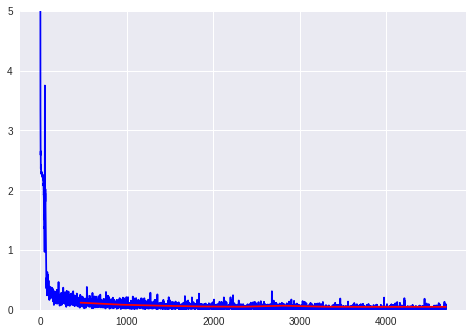

In [0]:
# Original data
train_w_preprocess(lambda x : np.floor(255 * x) )

## Min-max scaling

One of the simpliest preprocessing process is feature scaling:
* It consists in scaling data to be in a selected range.
* Very useful when combining inputs in different ranges (not this case)

\

$ X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}} $

\

Two scalings have been performed:

*  [0,1]
*  [-1,1]

\

Note: Imported dataset is already scaled at [0,1].

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299006

Validation set: Average loss: 0.3480, Accuracy: 8931/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.327817

Validation set: Average loss: 0.1951, Accuracy: 9417/10000 (94%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.262211

Validation set: Average loss: 0.1356, Accuracy: 9602/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.282476

Validation set: Average loss: 0.1102, Accuracy: 9668/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.198323

Validation set: Average loss: 0.0867, Accuracy: 9737/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.123399

Validation set: Average loss: 0.0756, Accuracy: 9778/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.073212

Validation set: Average loss: 0.0711, Accuracy: 9788/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.070336

Validation set: Average loss: 0.0668, Accuracy: 9793/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.045189

Validation set: Average loss: 0.0587, Accuracy: 9806/10000

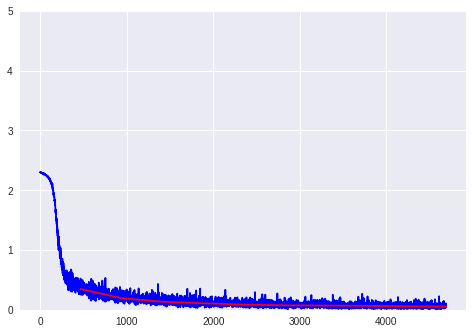

In [0]:
# Min-max scaling at [0,1]
train_w_preprocess(lambda x : x)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293870

Validation set: Average loss: 0.2047, Accuracy: 9392/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.263765

Validation set: Average loss: 0.1189, Accuracy: 9638/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.152739

Validation set: Average loss: 0.0875, Accuracy: 9742/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.065182

Validation set: Average loss: 0.0708, Accuracy: 9785/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.120997

Validation set: Average loss: 0.0596, Accuracy: 9823/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.092685

Validation set: Average loss: 0.0644, Accuracy: 9792/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.072868

Validation set: Average loss: 0.0478, Accuracy: 9846/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.036927

Validation set: Average loss: 0.0465, Accuracy: 9860/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.007956

Validation set: Average loss: 0.0422, Accuracy: 9863/10000

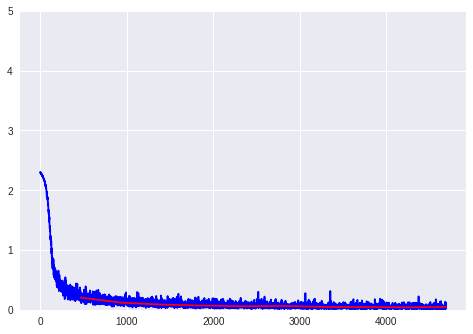

In [0]:
# Min-max scaling at [-1,1]
train_w_preprocess(lambda x : 2 * x - 1)

## Standarization

After preprocessing, the dataset has mean 0 and standard deviation 1.

$ x' = \frac{x-\hat{x}}{\sigma_x} $


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307025

Validation set: Average loss: 0.1654, Accuracy: 9545/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.131684

Validation set: Average loss: 0.1001, Accuracy: 9702/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.151984

Validation set: Average loss: 0.0721, Accuracy: 9792/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.063375

Validation set: Average loss: 0.0613, Accuracy: 9814/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.085295

Validation set: Average loss: 0.0533, Accuracy: 9835/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.053539

Validation set: Average loss: 0.0447, Accuracy: 9864/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.007766

Validation set: Average loss: 0.0433, Accuracy: 9858/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.043455

Validation set: Average loss: 0.0399, Accuracy: 9873/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.079406

Validation set: Average loss: 0.0406, Accuracy: 9868/10000

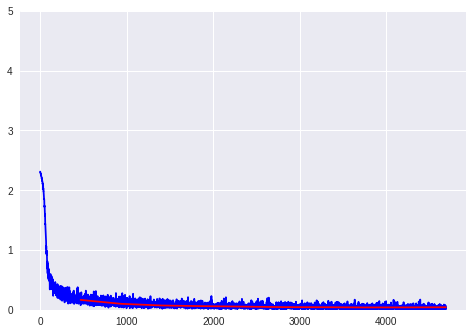

In [0]:
# standarize
mnist_mean = 0.1307
mnist_stddev = 0.3081
train_w_preprocess(lambda x : (x - mnist_mean) / mnist_stddev)

## Results

These are the results obtained are the following:

|Pre-processing method|<center>Accuracy</center>|<center>Epochs until 98%</center>| 
|------------------------------------|------------------------------------------|-------------------------------------------------------|
|Without pre-processing|<center>98.41%</center>    |<center>3</center>                                 |
|Scaling [0,1]                       |<center>98.29%</center>   |<center>6</center>                                 | 
|Scaling [-1,1]                      |<center>98.41%</center>   |<center>4</center>                                 | 
|Standarization                  |<center>98.63%</center>   | <center>3</center>                                |

\

* Accurancy results are very similar, the maximum difference is 0.34%
* The fastest trainings are without pre-processing and with standarization

##Conclusions

Surprisingly, pre-processing does not improve very much the results and, in some cases, results get worse. Some possible explanations to this fact are exposed below:

* Min-max scaling is very useful when combining input data, in different ranges. In this case, the whole data is in range [0, 255], so no scaling is really required and, as can be seen, results are lightly worse, specially the speed.
* Standarization is needed when input data contain outliers, which can cause min-max scaling not being the best option. This is not this case, but even so this is the best option at all.
